In [1]:
import re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [2]:
df = pd.read_pickle('absdata.p')

In [3]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [4]:
# 길이 100미만 삭제
indexes = []
for x in range(0,len(df)):
    if(len(df['clean_train_abstract'][x])<100):
        indexes.append(x)

In [9]:
indexes[2]

377

In [10]:
df['clean_train_abstract'][377]

'present author subject annual index publication'

In [11]:
df = df.drop(indexes)
df.index = range(len(df.index))

In [125]:
data_words = list(sent_to_words(df['clean_train_abstract']))

bigram = gensim.models.Phrases(data_words, min_count=2, threshold=20) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

data_words_bigrams = make_bigrams(data_words)

id2word = corpora.Dictionary(data_words_bigrams)

texts = data_words_bigrams

# corpus 만듦
corpus = [id2word.doc2bow(text) for text in texts]

In [126]:
# 뽑을 토픽의 개수
num_topics = 12

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=20,
alpha='auto',
per_word_topics=True)

In [36]:
lda_model.save(str(num_topics)+'_lda_model.model')

In [127]:
# Compute Perplexity - 낮을수록 좋다
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
 
# Compute Coherence Score - 높을수록 좋다 (0~1사이의 값)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.933361385545737

Coherence Score:  0.39834177317277697


In [42]:
lda_model = lda_model.load('12_lda_model.model')

In [40]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [43]:
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [46]:
absTopicTable = pd.DataFrame(index=np.arange(0, len(corpus)),columns=[x for x in range(12)])
absTopicTable.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
import time

start = time.time()
count = 0
for i,doc in enumerate(corpus):
    if(i%1000==0):
        print('~%d times :'%i + str(time.time()-start))
        start = time.time()
    for freq in lda_model.get_document_topics(doc):
        absTopicTable.loc[i,freq[0]] = freq[1]

~0 times :9.083747863769531e-05
~1000 times :68.38283586502075
~2000 times :71.26316905021667
~3000 times :70.51869702339172
~4000 times :74.32322311401367
~5000 times :75.76042175292969
~6000 times :76.73870825767517
~7000 times :79.97685885429382
~8000 times :79.89216828346252
~9000 times :83.92854714393616
~10000 times :79.82284712791443
~11000 times :80.64906001091003
~12000 times :80.60577583312988


In [53]:
# table 저장
probTable_name = 'doc_per_Topicprob_12.p'
absTopicTable.to_pickle(probTable_name)

In [54]:
doc_per_Topicprob = pd.read_pickle(probTable_name)

In [55]:
doc_per_Topicprob = absTopicTable.fillna(0)
doc_per_Topicprob.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.020531,0.029747,0.241805,0.172464,0.023211,0.011867,0.191602,0.013301,0.097525,0.309500,0.077546,0.010668
1,0.103145,0.016687,0.115218,0.147445,0.015073,0.014108,0.014510,0.029326,0.022410,0.361029,0.136884,0.024164
2,0.117440,0.170243,0.234308,0.110922,0.000000,0.000000,0.014382,0.016160,0.014899,0.043534,0.267562,0.000000
3,0.196721,0.040128,0.098700,0.249598,0.013371,0.000000,0.000000,0.046572,0.000000,0.102683,0.232052,0.000000
4,0.029044,0.054693,0.213725,0.042339,0.000000,0.000000,0.000000,0.027080,0.048049,0.217357,0.348338,0.000000


In [154]:
doc_per_Topicprob.shape

(11964, 13)

In [57]:
df[['pubDate','abstract']].shape()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12073 entries, 0 to 12072
Data columns (total 2 columns):
pubDate     12073 non-null object
abstract    12073 non-null object
dtypes: object(2)
memory usage: 188.7+ KB


In [58]:
doc_per_Topicprob['pubDate'] = df['pubDate']

In [59]:
cols = list(doc_per_Topicprob.columns.values)
cols.insert(0,'pubDate')
cols = cols[:-1]
cols

['pubDate', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [60]:
doc_per_Topicprob[cols].head()

,pubDate,0,1,2,3,4,5,6,7,8,9,10,11
0,2015-01-01,0.020531,0.029747,0.241805,0.172464,0.023211,0.011867,0.191602,0.013301,0.097525,0.309500,0.077546,0.010668
1,2015-01-01,0.103145,0.016687,0.115218,0.147445,0.015073,0.014108,0.014510,0.029326,0.022410,0.361029,0.136884,0.024164
2,2015-07-01,0.117440,0.170243,0.234308,0.110922,0.000000,0.000000,0.014382,0.016160,0.014899,0.043534,0.267562,0.000000
3,2015-07-01,0.196721,0.040128,0.098700,0.249598,0.013371,0.000000,0.000000,0.046572,0.000000,0.102683,0.232052,0.000000
4,1900-01-01,0.029044,0.054693,0.213725,0.042339,0.000000,0.000000,0.000000,0.027080,0.048049,0.217357,0.348338,0.000000


In [61]:
doc_per_Topicprob = doc_per_Topicprob[cols]

In [62]:
doc_per_Topicprob.head()

,pubDate,0,1,2,3,4,5,6,7,8,9,10,11
0,2015-01-01,0.020531,0.029747,0.241805,0.172464,0.023211,0.011867,0.191602,0.013301,0.097525,0.309500,0.077546,0.010668
1,2015-01-01,0.103145,0.016687,0.115218,0.147445,0.015073,0.014108,0.014510,0.029326,0.022410,0.361029,0.136884,0.024164
2,2015-07-01,0.117440,0.170243,0.234308,0.110922,0.000000,0.000000,0.014382,0.016160,0.014899,0.043534,0.267562,0.000000
3,2015-07-01,0.196721,0.040128,0.098700,0.249598,0.013371,0.000000,0.000000,0.046572,0.000000,0.102683,0.232052,0.000000
4,1900-01-01,0.029044,0.054693,0.213725,0.042339,0.000000,0.000000,0.000000,0.027080,0.048049,0.217357,0.348338,0.000000


In [63]:
doc_per_Topicprob['pubDate'] = pd.to_datetime(doc_per_Topicprob['pubDate'], format='%Y-%m-%d', errors='coerce')

In [64]:
doc_per_Topicprob = doc_per_Topicprob[~ doc_per_Topicprob['pubDate'].isnull()]

In [67]:
doc_per_Topicprob.shape

(11964, 13)

In [65]:
Topicprob_from2004 = doc_per_Topicprob[doc_per_Topicprob.pubDate >= pd.to_datetime("2004-01-01")]

In [66]:
Topicprob_from2004.shape

(8655, 13)

In [69]:
sorted_by_date = Topicprob_from2004.sort_values(by='pubDate')
sorted_by_date.head()

,pubDate,0,1,2,3,4,5,6,7,8,9,10,11
2032,2004-01-01,0.122025,0.063812,0.111958,0.208369,0.000000,0.000000,0.010760,0.107579,0.000000,0.046298,0.253237,0.064776
4327,2004-01-01,0.048664,0.282993,0.293096,0.042974,0.014000,0.000000,0.000000,0.042676,0.037607,0.115100,0.110963,0.000000
2031,2004-01-01,0.052467,0.197789,0.247565,0.080344,0.013221,0.021024,0.032485,0.095776,0.000000,0.069303,0.170522,0.012322
2030,2004-01-01,0.022311,0.207719,0.111501,0.228563,0.000000,0.000000,0.055874,0.043676,0.000000,0.088588,0.198808,0.025080
2029,2004-01-01,0.029906,0.210118,0.171445,0.018147,0.013608,0.000000,0.040615,0.037048,0.000000,0.034574,0.288348,0.145807


In [70]:
sorted_by_date = sorted_by_date.set_index('pubDate', inplace=False)
sorted_by_date.head()

,0,1,2,3,4,5,6,7,8,9,10,11
pubDate,,,,,,,,,,,,
2004-01-01,0.122025,0.063812,0.111958,0.208369,0.000000,0.000000,0.010760,0.107579,0.000000,0.046298,0.253237,0.064776
2004-01-01,0.048664,0.282993,0.293096,0.042974,0.014000,0.000000,0.000000,0.042676,0.037607,0.115100,0.110963,0.000000
2004-01-01,0.052467,0.197789,0.247565,0.080344,0.013221,0.021024,0.032485,0.095776,0.000000,0.069303,0.170522,0.012322
2004-01-01,0.022311,0.207719,0.111501,0.228563,0.000000,0.000000,0.055874,0.043676,0.000000,0.088588,0.198808,0.025080
2004-01-01,0.029906,0.210118,0.171445,0.018147,0.013608,0.000000,0.040615,0.037048,0.000000,0.034574,0.288348,0.145807


In [80]:
sorted_by_date.to_pickle('sorted_by_date_12topics.p')

In [71]:
# http://enjoyiot.tistory.com/category/Python 참조
docs_in_year = sorted_by_date.resample(rule='A').size() # rule이 'A'면 annual, 'M'이면 month, 분기별로 판단하는 rule도 존재
docs_in_year

pubDate
2004-12-31    374
2005-12-31    456
2006-12-31    726
2007-12-31    787
2008-12-31    526
2009-12-31    577
2010-12-31    506
2011-12-31    712
2012-12-31    720
2013-12-31    435
2014-12-31    480
2015-12-31    551
2016-12-31    562
2017-12-31    649
2018-12-31    594
Freq: A-DEC, dtype: int64

In [108]:
keywords_per_topic = pd.DataFrame( [(word[0],round(word[1],4)) for word in lda_model.show_topic(topic_num)] for topic_num in range(12))

In [110]:
keywords_per_topic.to_csv('keywords_per_topic.csv')

[('channel', 0.0562309),
 ('wireless', 0.038115203),
 ('power', 0.035148334),
 ('sensor', 0.032365065),
 ('transmission', 0.023582095),
 ('mobility', 0.019358763),
 ('frequency', 0.014506639),
 ('wireless_sensor', 0.013902627),
 ('signal', 0.013225372),
 ('sensing', 0.012053364)]

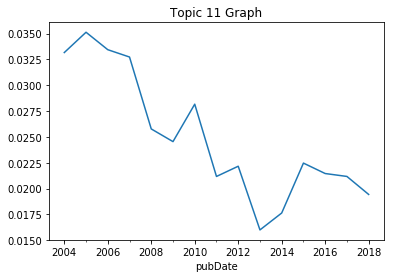

In [153]:
topic_num = 11
sorted_by_date[topic_num].resample('Y').mean().plot(title='Topic '+str(topic_num)+' Graph')
plt.title = str(topic_num)+'번 토픽'
lda_model.show_topic(topic_num)

In [122]:
import matplotlib.pyplot as plt